In [86]:
# Install the required packages for the notebook

%pip install boto3 nibabel numpy matplotlib torch torchvision torchaudio pillow tensorflow


Note: you may need to restart the kernel to use updated packages.


In [87]:
# Sprint 1: Reading NII files from S3 and saving PNGs

import boto3
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import tempfile
import os

# Initialize S3 resource and specify bucket and folder details
s3 = boto3.resource('s3')
bucket_name = 'chemocraft-data'
folder_path = 'MICCAI_BraTS2020_TrainingData/'
# folder_path = 'Data/BraTS20_Training_369 copy/'
bucket = s3.Bucket(bucket_name)

def plot_slice(data, crop, slice_idx, filename):
    # Crop the specified slice
    slice_2d = data[:, :, slice_idx]
    cropped_slice = slice_2d[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    
    # Display the cropped slice with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_slice, cmap='gray')
    plt.title(f'Slice {slice_idx} of {filename}')
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()

def savePNG(data, crop, filename):    
    # Prepare directory structure
    fileWOext = filename.split(".")[0]
    TrainingCount = fileWOext.split("_")[-2]
    ScanType = fileWOext.split("_")[-1]
    slice_path = f"brain_slices/{TrainingCount}/{ScanType}/"
    print(f"Saving in directory: {slice_path}")

    # Iterate through each slice in the Z-Dimiension data and save as PNG
    for slice_idx in range(data.shape[2]):
        # Crop each slice
        slice_2d = data[:, :, slice_idx]
        cropped_slice = slice_2d[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
        png_filename = f"{slice_path}{slice_idx}.png"
        
        # Local Saving
        # try:
        #     # Create directories as needed and save each slice
        #     os.makedirs(slice_path, exist_ok=True)
        #     mpimg.imsave(png_filename, cropped_slice, cmap='gray')
        # except Exception as e:
        #     print(f"ERROR: directory could not be made due to {e}")
        
        # Upload each PNG to S3
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_png:
            mpimg.imsave(temp_png.name, cropped_slice, cmap='gray')
            temp_png.flush()
            temp_png.seek(0)
            temp_png_name = temp_png.name  # Store the name to use it after the file is closed

        try:
            s3.Bucket(bucket_name).upload_file(temp_png_name, f"Akshay/{png_filename}")
            os.remove(temp_png_name)
        except Exception as e:
            print(f"ERROR: Could not upload or delete temporary PNG file due to {e}")

def render_nii_from_s3(filename, path):
    print(f"Fetching file: {filename}")

    try:
        obj = bucket.Object(path + filename)
        file_stream = io.BytesIO(obj.get()['Body'].read())
    except s3.meta.client.exceptions.NoSuchKey as e:
        print(f"ERROR: The specified key does not exist: {path + filename}")
        return
    except Exception as e:
        print(f"ERROR: An unexpected error occurred: {e}")
        return

    with tempfile.NamedTemporaryFile(suffix='.nii', delete=False) as temp_file:  # Prevent auto-deletion
        temp_file.write(file_stream.getvalue())
        temp_file.flush()

        temp_file_path = temp_file.name
        print(f"Temporary file created: {temp_file_path}")

    try:
        img = nib.load(temp_file_path)
        data = img.get_fdata()

        print(f"Data shape for {filename}: {data.shape}")
        
        if data.size == 0:
            print(f"No data found in {filename}")
            return

        # Define crop dimensions
        cropleft = 25
        cropright = data.shape[0] - 15
        cropbottom = data.shape[1] - 40
        croptop = 40        
        crop = np.array([[croptop, cropbottom], [cropleft, cropright]])
        
        # Save the PNGs and plot a sample slice
        savePNG(data, crop, filename)
        
        # slice_idx = 88  # Choose a slice index for sample display
        # plot_slice(data, crop, slice_idx, filename)

    except Exception as e:
        print(f"Error loading file {filename}: {e}")
        
    finally:
        try:
            os.remove(temp_file_path)
            print(f"Deleted temporary file: {temp_file_path}")
        except OSError as cleanup_error:
            print(f"Error deleting temp file: {cleanup_error}")

def find_and_render_nii_files():
    found_files = False

    subfolders = set()  # use a set to ensure unique subfolder names
    for obj in bucket.objects.filter(Prefix=folder_path):
        # Get the path after the 'Data/' prefix and split it by '/'
        path_parts = obj.key[len(folder_path):].split('/')
        
        # Check if there's at least one part (indicating a subfolder)
        if len(path_parts) > 1:
            subfolders.add(f'{path_parts[0]}/')  # Add the subfolder name
            
    subfolders = sorted(subfolders)

    print(f"Root Directory: {folder_path.split('/')[0]}")
    # print(subfolders)

    for subfolder in subfolders:
        path = folder_path + subfolder
        print(f"Reading S3 in {path}")
        for obj in bucket.objects.filter(Prefix=path):
            if obj.key.endswith('.nii'):
                print(f"path: {path}")
                found_files = True
                filename = obj.key.split('/')[-1]  # Extract filename from path
                print(f"Found .nii file: {filename}")
                render_nii_from_s3(filename, path)

    if not found_files:
        print(f"No .nii files found in the folder {folder_path}")

# Main function
# find_and_render_nii_files()

In [88]:
# Sprint 2: GAN for Brain MRI Generation

import io
from io import BytesIO
import keras
import numpy as np
from PIL import Image
import boto3
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import Sequence # type: ignore # type: ignore
from keras.preprocessing.image import img_to_array, load_img # type: ignore

# Initialize S3 resource and specify bucket and folder details
s3 = boto3.resource('s3')
bucket_name = 'chemocraft-data'
bucket = s3.Bucket(bucket_name)
folder_prefix = "Akshay/brain_slices/"

def load_images_from_s3(bucket, folder_prefix):
    print(f"Loading images from S3 bucket: {bucket_name}/{folder_prefix}")
    images = []
    for obj in bucket.objects.filter(Prefix=folder_prefix):
        if obj.key.endswith('.png'):
            file_stream = io.BytesIO(obj.get()['Body'].read())
            image = load_img(file_stream, target_size=(200, 160), color_mode='grayscale')
            image = img_to_array(image) / 255.0  # Normalize to [0, 1]
            images.append(image)
    return np.array(images)


# Generator Model
def build_generator(latent_dim=100, output_shape=(200, 160, 1)):
    """
    Builds the generator model for a GAN.
    
    Parameters:
    latent_dim (int): The size of the input latent vector.
    output_shape (tuple): The desired shape of the generated images (height, width, channels).
    
    Returns:
    A compiled Keras Sequential model.
    """
    model = models.Sequential(name="Generator")
    print("Building Generator Model")
    
    # Input layer
    print(f"Output shape: {output_shape}")
    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(128 * 25 * 20, activation="relu"))
    model.add(layers.Reshape((25, 20, 128)))
    
    # Transposed convolutional layers to upsample
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu"))
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu"))
    # model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", activation="relu"))  
    # model.add(layers.Conv2DTranspose(8, kernel_size=4, strides=4, padding="same", activation="relu"))  
    model.add(layers.Conv2D(8, kernel_size=3, padding="same", activation="tanh"))
    model.add(layers.Conv2DTranspose(output_shape[2], kernel_size=4, strides=2, padding="same", activation="relu"))
    model.add(layers.Activation("tanh"))
    # model.summary()

    model.compile(optimizer="adam", loss="binary_crossentropy")
    return model

# Discriminator Model
def build_discriminator(input_shape):
    """
    Builds the discriminator model for a GAN.
    
    Parameters:
    input_shape (tuple): The shape of the input images (height, width, channels).
    
    Returns:
    A compiled Keras Sequential model.
    """
    model = models.Sequential(name="Discriminator")
    print("Building Discriminator Model")
    
    # Input layer
    print(f"Input shape: {input_shape}")
    
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, kernel_size=4, strides=2, padding="same"))
    model.add(layers.Conv2D(32, kernel_size=4, strides=2, padding="same", input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Flatten and output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    # model.summary()
    
    model.compile(optimizer="adam", loss="binary_crossentropy")
    return model

# GAN Model
def compile_gan(generator, discriminator, latent_dim):
    # Make the discriminator layers non-trainable
    print("Building GAN Model")
    
    z = layers.Input(shape=(latent_dim,))
    img = generator(z)
    discriminator.trainable = False
    validity = discriminator(img) 
    
    # Compile the combined GAN model
    gan = keras.Model(z, validity, name="GAN")
    gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
    gan._name = "GAN"
    return gan

In [89]:
# Instantiate models
latent_dim = 100
img_shape = (200, 160, 1)
generator = build_generator(latent_dim=latent_dim, output_shape=img_shape)
discriminator = build_discriminator(input_shape=img_shape)
gan = compile_gan(generator, discriminator, latent_dim)

# Display model summaries
discriminator.summary()
generator.summary()
gan.summary()

Building Generator Model
Output shape: (200, 160, 1)
Building Discriminator Model
Input shape: (200, 160, 1)
Building GAN Model


c:\Users\grnpr\anaconda3\envs\chemocraft\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\grnpr\anaconda3\envs\chemocraft\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_132 (Conv2D)             │ (None, 100, 80, 32)    │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 50, 40, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_121 (LeakyReLU)     │ (None, 50, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 25, 20, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_122 (LeakyReLU)     │ (None, 25, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_135 (Conv2D)             │ (None, 13, 10, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_123 (LeakyReLU)     │ (None, 13, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 16640)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │        16,641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,633 (772.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 197,633 (772.00 KB)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 64000)          │     6,464,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_38 (Reshape)            │ (None, 25, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_140            │ (None, 50, 40, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_141            │ (None, 100, 80, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 100, 80, 8)     │         4,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_142            │ (None, 200, 160, 1)    │           129 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_95 (Activation)      │ (None, 200, 160, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,690,121 (25.52 MB)

 Trainable params: 6,690,121 (25.52 MB)

 Non-trainable params: 0 (0.00 B)

Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_116 (InputLayer)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Sequential)          │ (None, 200, 160, 1)    │     6,690,121 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │       197,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,887,754 (26.27 MB)

 Trainable params: 6,690,121 (25.52 MB)

 Non-trainable params: 197,633 (772.00 KB)

Loading images from S3 bucket: chemocraft-data/Akshay/brain_slices/320/
Training GAN...


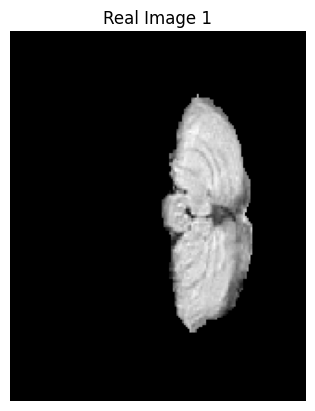

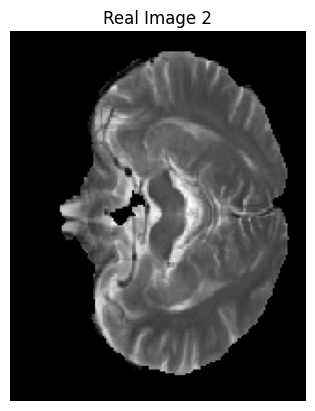

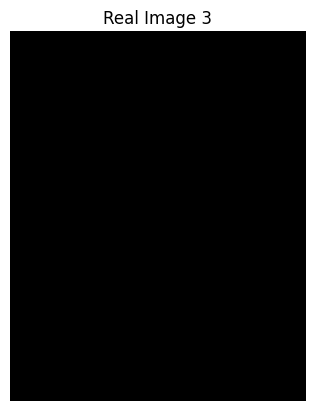

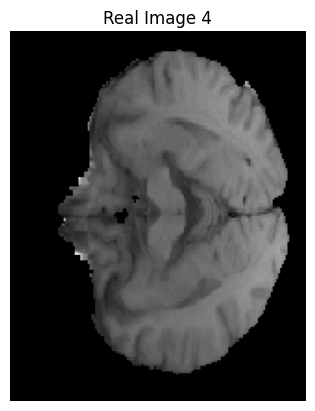

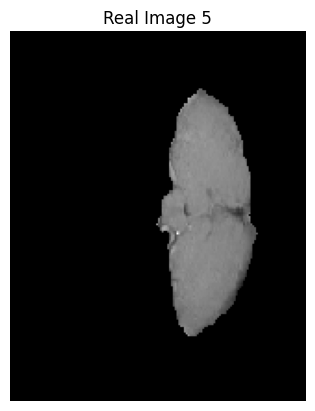

AttributeError: 'NoneType' object has no attribute 'update_state'

In [ ]:
# Training
epochs = 50
batch_size = 155*4
half_batch = batch_size // 2

def train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size):
    # Load images from S3
    s3 = boto3.resource('s3')   
    bucket = s3.Bucket('chemocraft-data')
    images = load_images_from_s3(bucket, 'Akshay/brain_slices/320/')

    half_batch = 64//2
    
    print("Training GAN...")
    for epoch in range(epochs):
        # Train discriminator with real images
        idx = np.random.randint(0, images.shape[0], half_batch)
        real_images = images[idx]
        real_labels = np.ones((half_batch, 1))
        
        # Print images from the data generator
        # for i in range(5):  # Print 5 images
        #     img = real_images[i]
        #     plt.imshow(img[:, :, 0], cmap='gray')
        #     plt.title(f"Real Image {i+1}")
        #     plt.axis('off')
        #     plt.show()
        
        # ************Apparantly the optmizer is coming out to be null here************
        d_loss_real = discriminator.fit(real_images, real_labels, epochs=1, verbose=0)
        
        # Generate fake images
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1))
        
        # Display fake images using matplotlib
        # fig, axs = plt.subplots(4, 8, figsize=(15, 8))
        # cnt = 0
        # for i in range(4):
        #     for j in range(8):
        #         axs[i, j].imshow(fake_images[cnt, :, :, 0], cmap='gray')
        #         axs[i, j].axis('off')
        #         cnt += 1
        # plt.show()
        
        d_loss_fake = discriminator.fit(fake_images, fake_labels, epochs=1, verbose=0)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        misleading_labels = np.ones((batch_size, 1))
        
        g_loss = gan.fit(noise, misleading_labels, epochs=1, verbose=0)
        
        # Print loss values
        print(f"{epoch+1}/{epochs}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")
        
train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size)

In [ ]:
def generate_3d_image(generator, latent_dim, num_slices=150):
    noise = np.random.normal(0, 1, (num_slices, latent_dim))
    generated_slices = generator.predict(noise)
    generated_3d_image = np.stack(generated_slices, axis=0)  # Shape: (num_slices, 200, 160)
    return generated_3d_image

# generated_3d_image = generate_3d_image(generator, latent_dim=100, num_slices=150)

# Display the generated 3D image
# fig, axs = plt.subplots(10, 15, figsize=(15, 10))
# cnt = 0
# for i in range(10):
#     for j in range(15):
#         axs[i, j].imshow(generated_3d_image[cnt, :, :, 0], cmap='gray')
#         axs[i, j].axis('off')
#         cnt += 1
# plt.show()

# Save the models
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')
gan.save('gan_model.h5')
